# OCR Correction in Dutch Government Documents 
**Code for the TPDL 2023 Short paper "Making PDFs Accessible for Visually Impaired
Users (and Findable for Everybody Else)"**

In this notebook we present the code used to obtain the results we presented in the TPDL short paper currently under review. We will be testing a simple method to detect bad segments in OCRed text of released government documents using wordlist membership, which we will be using to compare the quality of the original text in the PDF (extracted using pdftotext) and text extracted using Tesseract, and see whether the usage of Tesseract increases the overall quality. We then also use ChatGPT to correct the texts and evaluate the effectiveness of this measure.

**Note**: In line with OpenAI policies we do not share our private API token, so you will have to request your own, the free OpenAI token that grants a 5 dollor budget should be more than enough to run the examples that we did.

## Index
1. [Setting Up](#setup)
2. [Word List Based Detection](#wordlists)
3. [PDFToText and Tesseract Comparison](#comparison)
3. [ChatGPT](#chatgpt)

<h1><a id="setup"> Setting Things Up</a></h1>

First we are going to detect bad segments based on a list of Dutch words. We consider segments bad if they contain words that are not in the word list, but we also consider segments bad if there are at most N consecutive good words in the segments, where N is a parameter. We update the wordlist with words from the ParlaMint dataset as this is also from the political domain, and might give us some more domain specific words. All the required files are present in the `data` folder.

In [14]:
# Load in parlamint
import pandas as pd
from tqdm import tqdm
from typing import List
from cleantext import clean
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

# We also load a preprocessing file, which contains functions for getting the updated word list,
# the full tokenization/cleaning pipeline as well as several other functions.
from preprocessing import *

In [15]:
# Load the word list file that has been updated with ParlaMint words
with open('../data/wordlist.txt', 'r') as f:
        dutch_wordlist = set([item.strip() for item in f.readlines()])

In [16]:
print("The word list (with parlamint added) contains %d unique words" % len(dutch_wordlist))

The word list (with parlamint added) contains 538039 unique words


The above wordlist has been constructed as a combination from the wordlist from the ParlaMint dataset and the wordlist from the TaalUnie. We will now also do a small comparison to show the differences between the wordlists, and how much we added by adding the word list from ParlaMint.

In [17]:
# Load in the parlamint wordlist and the wordlist without parlamint seperately.
with open('../data/taalunie_wordlist.txt', 'r') as f:
        dutch_wordlist_without_parlamint = set([item.strip().lower() for item in f.readlines()])
        
with open('../data/parlamint_wordlist.txt', 'r') as f:
        parlamint_wordlist = set([item.strip().lower() for item in f.readlines()])

In [18]:
print("The TaalUnie word list has a total of %d unique words" % len(dutch_wordlist_without_parlamint))
print("The Parlamint dataset has a total of %d unique words" % len(parlamint_wordlist))
print("Together both word list contain %d words" % (len(dutch_wordlist_without_parlamint)+len(parlamint_wordlist)))
print("The general wordlist and the parlamint word list have %d words in common" % len(dutch_wordlist_without_parlamint & parlamint_wordlist))
print("Taalunie has %d words not occurring in the ParlaMint dataset" % len(dutch_wordlist_without_parlamint-parlamint_wordlist))
print("ParlaMint has %d words not occurring in the TaalUnie dataset" % len(parlamint_wordlist-dutch_wordlist_without_parlamint))

The TaalUnie word list has a total of 409555 unique words
The Parlamint dataset has a total of 239159 unique words
Together both word list contain 648714 words
The general wordlist and the parlamint word list have 109809 words in common
Taalunie has 299746 words not occurring in the ParlaMint dataset
ParlaMint has 129350 words not occurring in the TaalUnie dataset


### Loading in the dataset

We load in the text from all the pages that are part of besluiten/decisions and apply some filtering to remove pages that have been missclassified as being part of a besluit. The final version is available in the github repo.

In [19]:
experiment_dataframe = pd.read_csv('../data/data.csv.gz')
# set the index properly so its unique for every page
experiment_dataframe['DOCUMENT_ID'] = experiment_dataframe['ID'].str.split('.').str[:-1].str.join(sep='')

<h1><a id="wordlists">Word List Membership Detection</a></h1>

Now that we have an updated word list we will be using this to detect bad passages in the besluiten text. We will be doing this for both the Tesseract and pdftotext types and makes comparisons, as well as playing with the tolerance threshold on good words, to see the impact of this threshold. Let's code up the rules in numpy first, then compare threshold, and then compare the two ocr types.


In [20]:
import numpy as np
class BadSegmentDetector:
    def __init__(self, word_list_path: str = '../data/wordlist.txt'):
        # Read in the word list
        with open(word_list_path, 'r') as f:
            all_dutch_words = set([item.strip().lower() for item in f.readlines()])
        # remove any numbers from the word list, as we have also remove them from the page tokens.
        self.word_list = set([item for item in all_dutch_words if not any(char.isdigit() for char in item)])

    def wordlist_membership(self, list_of_tokens: List[str]) -> List[bool]:
        # simply check whether a token appears in the word list or not
        return np.array([token in self.word_list for token in list_of_tokens])

    @staticmethod
    def preprocess(input_string: str, clean_input: bool = True) -> List[str]:
        """
        :param input_string: string containing the text to be preprocessed
        :param clean_input: boolean specifying whether to clean the input, 
        if this is Fale then only tokenization is performed.
        Function that handles the preprocessing of input text performs two steps
        1. Normalization by removing non-unicode characters and normalizing whitespace
        2. Tokenization using nltk
        :returns: A list of tokens
        """
        # perform normalization and tokenization
        if clean_input:
            input_string = clean_func(input_string)
        tokenized_text = word_tokenize(input_string)
        return tokenized_text
        
    def detect_bad_segments(self, input_text: str, tolerance=3, clean_input: bool=True) -> np.ndarray:
        """
        Function that detects bad segment in a list of input tokens based on the 
        word list.
        :param inpuput_text: string that contains the input text for which we 
        calculate the bad segments
        :param tolerance: integer specifying the tolerance of good words within a 
        pad segment
        :param clean_input: boolean specifying whether to clean the input, 
        if this is Fale then only tokenization is performed.
        :returns: numpy array with a boolean vector for each token indication whether it is 
        part of a bad segment or not.
        """
        # Get the input tokens from the text
        tokenized_sample = self.preprocess(input_text, clean_input=clean_input)
        # Get a boolean vector for each word in the in text indicating whether
        # it is in the wordlist or not.
        word_list_array = self.wordlist_membership(tokenized_sample)
        # Get the words that are in the wordlist
        wordlist_members = word_list_array.nonzero()[0]
        # Get the start of good segment
        good_prefixes = np.diff(wordlist_members, prepend=-2)
        good_prefixes = wordlist_members[good_prefixes > 1]

        # Check whether a good segment is within the tolerance
        # if it is its part of a bad segment, otherwise it is ok.
        for item in good_prefixes:
            sequence = word_list_array[item: item+tolerance]
            if not np.all(sequence):
                word_list_array[item:item+tolerance-1] = False

        return np.logical_not(word_list_array)

In [21]:
# set up the segmenter for some examples
wordlist_segmenter = BadSegmentDetector()

We will test the segmenter on a sample from the dataet, highlightin bad segments in the text with light blue.

In [22]:
from IPython.display import HTML, display, Markdown
sample_index = 2014
sample_page_output = wordlist_segmenter.detect_bad_segments(experiment_dataframe['original'].iloc[sample_index])
page_tokens = wordlist_segmenter.preprocess(experiment_dataframe['original'].iloc[sample_index])

In [23]:
# Show the bad segments with colored markup
display(Markdown(" ".join("<p style='background-color:powderblue;display: inline-block;'>%s</p>" % page_tokens[i] if sample_page_output[i] else page_tokens[i] for i in range(len(page_tokens)))))

<p style='background-color:powderblue;display: inline-block;'>1van</p> opvragen archief verzonden donderdag november aan <p style='background-color:powderblue;display: inline-block;'>wobpublicaties</p> onderwerp fw opvragen informatie archief verg <p style='background-color:powderblue;display: inline-block;'>unningen</p> <p style='background-color:powderblue;display: inline-block;'>donkeregaard</p> te utrecht van opvragen archief verzonden donderdag november aan onderwerp re opvragen informatie archief vergunningen geachte mevrouw wij hebben besloten om de door u gevraagde informatie openbaar te maken met uitzondering van persoonsgegevens zie voor nadere toelichting hieronder klik op deze link om het dossier <p style='background-color:powderblue;display: inline-block;'>hzwabo</p> <p style='background-color:powderblue;display: inline-block;'>te</p> <p style='background-color:powderblue;display: inline-block;'>do</p> <p style='background-color:powderblue;display: inline-block;'>wnloaden</p> wij raden u aan de bestanden binnen dagen te downloaden na deze periode worden ze automatisch verwijderd toelichting op verstrekte informatie het belang van de eerbiediging van de persoonlijke le <p style='background-color:powderblue;display: inline-block;'>venssfeer</p> artikel lid sub <p style='background-color:powderblue;display: inline-block;'>e</p> wob vinden wij zwaarder wegen dan het belang van openbaar maki ng van deze gegevens om die reden zijn de persoonsgegevens onleesbaar gemaakt op tekeningen en rapporten kan auteursrecht zitten als u deze informatie wilt hergebruiken dient u aan de rechthebbende toestemming te vragen hebt u nog vragen reageer dan op deze email de gemeente utrecht is continu be <p style='background-color:powderblue;display: inline-block;'>zig</p> om de dienstverlening te <p style='background-color:powderblue;display: inline-block;'>verb</p> <p style='background-color:powderblue;display: inline-block;'>eteren</p> wij zouden het op prijs stellen als u ons klanttevredenheidsonderzoek zou willen invullen dit kost slechts minuten van uw tijd klik hier om naar het onderzoek te gaan hartelijk dank hoogachtend namens het college van burgemeester en wethouders van utrecht drs ha lesscher directeur vergunningen toezicht en handhaving dit besluit wordt digitaal en zonder ondertekening verstuurd bezwaar maken bent u het niet eens met het besluit in deze brief dan kunt u daar tegen bezwaar maken dit moet u doen binnen weken na de datum va <p style='background-color:powderblue;display: inline-block;'>n</p> deze brief dat kan als volgt <p style='background-color:powderblue;display: inline-block;'></p> <p style='background-color:powderblue;display: inline-block;'>online</p> <p style='background-color:powderblue;display: inline-block;'>via</p> <p style='background-color:powderblue;display: inline-block;'></p> met een brief aan het college van burgemeester en wethouders van utrecht postbus ce utrecht in het <p style='background-color:powderblue;display: inline-block;'>bezwaarsch</p> <p style='background-color:powderblue;display: inline-block;'>rift</p> staat in elk geval uw naam adres telefoonnummer datum en handtekening kenmerk en datum van deze <p style='background-color:powderblue;display: inline-block;'>besluitbrief</p> reden van uw bezwaar

<h1><a id="comparison">Comparing the Original Text with Tesseract</a></h1>

In this part we will be comparing the quality of the original text with the output of the Tesseract model by comparing the statistics of the detected bad segments by our simple method. We will make distribution plots for a few of the statistics, namely the `number of bad segments`, the `bad ratio` and the `mean bad segment length`. Here we run with our default of 3 good tokens tolerance, which we will also use throughout the rest of the paper.

We have to be a bit careful here, as especially the original text has quite a lot of pages where text is missing, and this will influence the numbers that we take. We will add the information to the entire dataframe, but when making the results we will focus only on cases where both versions actually have text.

In [24]:
print("The original text has %d empty pages" % experiment_dataframe['original'].isna().sum())
print("Tesseract has %d empty pages" % experiment_dataframe['tesseract'].isna().sum())

The original text has 7908 empty pages
Tesseract has 658 empty pages


Below we will write a function that will calculate the bad segments for every page in our datasets, and will also calculate various statistics that we can then use to obtain the stats over both versions of text.

In [25]:
# First some code to get general stats on all text (or a selection)
def run_bad_segment_detection(input_dataframe: list, tolerance: int):
    """
    Function that runs that bad segment detection on a dataframe and returns
    general statistics on the bad segments in the text.
    """
    det = BadSegmentDetector()
    all_bad_segment_lengths = []
    all_segment_indices = []
    results = dict()
    for document_id, document in tqdm(input_dataframe.to_dict().items()):
        bad_segments = det.detect_bad_segments(document, tolerance=tolerance, clean_input=False)
        # skips empty pages
        if True in bad_segments:
            bad_segment_length = np.diff(np.where(np.concatenate(([bad_segments[0]],
                         bad_segments[:-1] != bad_segments[1:],
                         [True])))[0])[::2]
            num_bad_segments = len(bad_segment_length)
            all_bad_segment_lengths.extend(bad_segment_length)
        else:
            num_bad_segments = 0
            bad_segment_length = np.array([0])

        starts = np.nonzero(np.diff(bad_segments.astype(int)) == 1)[0]+1
        stops = np.nonzero(np.diff(bad_segments.astype(int)) == -1)[0]+1
        
        if bad_segments[0]:
            starts = np.insert(starts, 0, 0)
        if bad_segments[-1]:
            stops = np.append(stops, len(bad_segments))
            
        segment_indices = list(zip(starts, stops))
        all_segment_indices.append(segment_indices)

        mean_bad_segment_length = bad_segment_length.mean()
        num_bad_tokens = bad_segments.sum().astype(int)
        shortest_bad_segment, longest_bad_segment = bad_segment_length.min().astype(int), bad_segment_length.max().astype(int)
        results[document_id] = {'Number of bad Segments': num_bad_segments,
                            'Mean Bad Segment Length': mean_bad_segment_length,
                            'Max Bad Segment Length': longest_bad_segment,
                            'Min Bad Segment Length': shortest_bad_segment,
                            'Number of bad Tokens': num_bad_tokens,
                            'Bad Ratio': bad_segments.mean(),
                            'Num Tokens': len(bad_segments)}
        
    return pd.DataFrame.from_dict(results, orient='index'), all_bad_segment_lengths, all_segment_indices
        

In [26]:
# run the algorithm on both versions.
# We also get the length of all bad segments, and return this seperately as it is one a segment level, not a page level
pages_with_ocr = experiment_dataframe.dropna(subset=['original', 'tesseract'])
pdftotext_results, all_seg_lengths_pdf, pdftotext_indices = run_bad_segment_detection(pages_with_ocr['original'], tolerance=3)
tesseract_results, all_seg_lengths_tes, tesseract_indices = run_bad_segment_detection(pages_with_ocr['tesseract'], tolerance=3)

pdftotext_results['ID'] = pages_with_ocr['ID']
tesseract_results['ID'] = pages_with_ocr['ID']
pdftotext_results['publisher'] = pages_with_ocr['publisher']
tesseract_results['publisher'] = pages_with_ocr['publisher']
# Easiest thing is to make some distribution plots of the stats we got here between tesseract and pdftotext

100%|████████████████████████████████████| 17640/17640 [00:17<00:00, 991.41it/s]


In [27]:
pdftotext_results.drop(['ID', 'publisher'], axis=1).describe().round(1)

,Number of bad Segments,Mean Bad Segment Length,Max Bad Segment Length,Min Bad Segment Length,Number of bad Tokens,Bad Ratio,Num Tokens
count,17640.0,17640.0,17640.0,17640.0,17640.0,17640.0,17640.0
mean,7.8,6.7,10.3,5.1,22.9,0.1,291.6
std,9.4,68.0,71.7,66.6,84.5,0.2,157.9
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,3.0,1.0,1.0,1.0,4.0,0.0,188.0
50%,6.0,1.4,3.0,1.0,10.0,0.0,295.0
75%,11.0,2.0,6.0,1.0,19.0,0.1,401.0
max,659.0,3186.0,3186.0,3186.0,3186.0,1.0,4385.0


In [28]:
tesseract_results.drop(['ID', 'publisher'], axis=1).describe().round(1)

,Number of bad Segments,Mean Bad Segment Length,Max Bad Segment Length,Min Bad Segment Length,Number of bad Tokens,Bad Ratio,Num Tokens
count,17640.0,17640.0,17640.0,17640.0,17640.0,17640.0,17640.0
mean,6.5,1.9,4.2,1.2,13.0,0.1,293.9
std,5.8,5.2,10.1,4.5,28.2,0.1,138.1
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,3.0,1.0,1.0,1.0,4.0,0.0,196.0
50%,5.0,1.2,2.0,1.0,8.0,0.0,300.0
75%,9.0,1.8,4.0,1.0,14.0,0.1,401.0
max,190.0,381.0,488.0,381.0,1440.0,1.0,2084.0


In the two tables above we can see that statistics of the bad segments for both the original text and the Tesseract version, and we can clearly see that the Tesseract algorithm scores better on all aspects. Now we will do a bit more of a detailed analysis on the differences between the two versions.

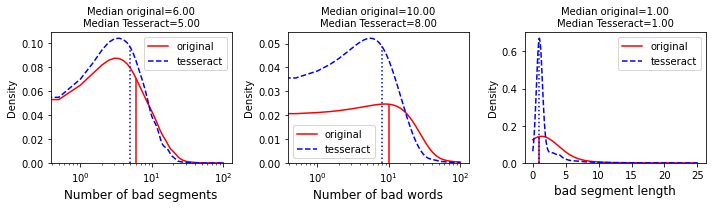

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
# Do the mean bad segment length first
sns.kdeplot(pdftotext_results['Number of bad Segments'], ax=axes[0],  clip = (0.0, 100.0), label="original", color='red')
sns.kdeplot(tesseract_results['Number of bad Segments'], ax=axes[0],  clip = (0.0, 100.0), label='tesseract', color='blue', linestyle='--')

axes[0].set_xscale('log')
axes[0].set_xlabel("Number of bad segments", fontsize=12)
axes[0].legend()

sns.kdeplot(pdftotext_results['Number of bad Tokens'], ax=axes[1], clip = (0.0, 100.0), label="original", color='red')
sns.kdeplot(tesseract_results['Number of bad Tokens'], ax=axes[1], clip = (0.0, 100.0), label='tesseract', color='blue', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel("Number of bad words", fontsize=12)
axes[1].legend()

sns.kdeplot(pd.Series(all_seg_lengths_pdf), ax=axes[2],  clip = (0.0, 25.0), label="original", color='red')
sns.kdeplot(pd.Series(all_seg_lengths_tes), ax=axes[2],  clip = (0.0, 25.0), label='tesseract', color='blue', linestyle='--')
axes[2].set_xlabel("bad segment length", fontsize=12)
axes[2].legend()

kdeline1 = axes[0].lines[0]
kdeline2 = axes[0].lines[1]
kdeline3 = axes[1].lines[0]
kdeline4 = axes[1].lines[1]
kdeline5 = axes[2].lines[0]
kdeline6 = axes[2].lines[1]

xs1, ys1 = kdeline1.get_xdata(), kdeline1.get_ydata()
xs2, ys2 = kdeline2.get_xdata(), kdeline2.get_ydata()
xs3, ys3 = kdeline3.get_xdata(), kdeline3.get_ydata()
xs4, ys4 = kdeline4.get_xdata(), kdeline4.get_ydata()
xs5, ys5 = kdeline5.get_xdata(), kdeline5.get_ydata()
xs6, ys6 = kdeline6.get_xdata(), kdeline6.get_ydata()

mean1 = pdftotext_results['Number of bad Segments'].median()
mean2 = tesseract_results['Number of bad Segments'].median()
mean3 = pdftotext_results['Number of bad Tokens'].median()
mean4 = tesseract_results['Number of bad Tokens'].median()
mean5 = pd.Series(all_seg_lengths_pdf).median()
mean6 = pd.Series(all_seg_lengths_tes).median()

height1 = np.interp(mean1, xs1, ys1)
height2 = np.interp(mean2, xs2, ys2)
height3 = np.interp(mean3, xs3, ys3)
height4 = np.interp(mean4, xs4, ys4)
height5 = np.interp(mean5, xs5, ys5)
height6 = np.interp(mean6, xs6, ys6)

axes[0].vlines(mean1, 0, height1, color='red')
axes[0].vlines(mean2, 0, height2, color='blue', ls=':')
axes[1].vlines(mean3, 0, height3, color='red')
axes[1].vlines(mean4, 0, height4, color='blue', ls=':')
axes[2].vlines(mean5, 0, height5, color='red')
axes[2].vlines(mean6, 0, height6, color='blue', ls=':')

# Get the medians and put them im the figures
axes[0].set_title("Median original=%.2f\nMedian Tesseract=%.2f" % (mean1, mean2), fontsize=10)
axes[1].set_title("Median original=%.2f\nMedian Tesseract=%.2f" % (mean3, mean4), fontsize=10)
axes[2].set_title("Median original=%.2f\nMedian Tesseract=%.2f" % (mean5, mean6), fontsize=10)

plt.tight_layout()
plt.show()


In [32]:
print("For pdftotext if we sum the length of all bad segments we get %d bad tokens" % sum(all_seg_lengths_pdf))
print("For Tesseract if we sum the length of all bad segments we get %d bad tokens" % sum(all_seg_lengths_tes))

For pdftotext if we sum the length of all bad segments we get 403078 bad tokens
For Tesseract if we sum the length of all bad segments we get 228727 bad tokens


## Comparing Bad Segments

Now that we have the bad segments for all the pages for both the original and the output from Tesseract, we can compare those bad segments and see where the two versions are different. For this we have to be a bit careful, as there is not always a 1 to 1 mapping from one version to the other, so we will only select the pages that have the same amount of tokens for both version

In [33]:
def get_overlap_info(list_of_indices_1, list_of_indices_2):
    """
    Function to calculate the overlap between two sets of annotations for bad segments,
    where both inputs should be lists with the starting indices of bad segments.
    :param list_of_indices_1: list of indices for bad segments for system 1
    :param list_of_indices_2: list of indices for bad segments for system 2
    :returns: three output statistics for the overlap between segments
        - no_overlap: percentage of clusters that have no overlap between system 1 and 2
        - some_overlap: percentage of clusters where there is some overlap between system 1 and 2
        but one is not a subset of the other.
        - subsegment: percentage of clusters where segment 2 is a subset of segment 1.
    
    """
    # let's get the average overlap as IoU
    no_overlap = 0
    some_overlap = 0
    subsegment = 0
    sets_1 = [set(range(start, stop)) for start, stop in list_of_indices_1]
    sets_2 = [set(range(start, stop)) for start, stop in list_of_indices_2]

    for set_1 in sets_1:
        if not any(set_1 & set_2 for set_2 in sets_2):
            no_overlap+=1
        elif any((set_1 & set_2 == set_1) for set_2 in sets_2):
            subsegment+=1
        else:
            for set_2 in sets_2:
                iou = len(set_1 & set_2) / len(set_1 | set_2)
                if iou > 0.5:
                    some_overlap+=1
                    
    return no_overlap, some_overlap, subsegment

In [34]:
matching_pages = tesseract_results['Num Tokens'] == pdftotext_results['Num Tokens']

In [35]:
total_no_overlap = 0
total_iou_vals = 0
total_subsegment = 0

for i in np.nonzero(np.array(matching_pages))[0]:
    no_overlap, iou_vals, subsegment = get_overlap_info(tesseract_indices[i], pdftotext_indices[i])
    total_no_overlap+=no_overlap
    total_iou_vals+=iou_vals
    total_subsegment+=subsegment
    
total_tesseract_segments = tesseract_results['Number of bad Segments'][matching_pages].sum()

print("For tesseract, there is no overlap in %.2f percent of the cases" % ((total_no_overlap/total_tesseract_segments)*100))
print("For tesseract,  in %.2f percent of the cases the prediction is a subset of pdftotext" % ((total_subsegment/total_tesseract_segments)*100))

For tesseract, there is no overlap in 28.18 percent of the cases
For tesseract,  in 69.24 percent of the cases the prediction is a subset of pdftotext


## Comparing across ministries

Apart from comparing the statistics in general, we also compare the differences between the two versionss for the ministries seperately, to gain more insights into the differences between the two versions, and the potential impact of switching to Tesseract.

In [36]:
pdftotext_results.publisher.fillna('', inplace=True)
tesseract_results.publisher.fillna('', inplace=True)

In [37]:
# Create a plot for the different ministeries
pdftotext_results_ministeries = pdftotext_results[pdftotext_results.publisher.str.startswith('mnre')]
tesseract_results_ministeries = tesseract_results[tesseract_results.publisher.str.startswith('mnre')]

In [38]:
translation_dict = {
 'mnre1109': 'OCW',
 'mnre1010': 'AZ',
 'mnre1013': 'BZ',
 'mnre1018': 'DEF',
 'mnre1025': 'VWS',
 'mnre1034': 'BZK',
 'mnre1045': 'EZK',
 'mnre1058': 'J & V',
 'mnre1073': 'SZW',
 'mnre1090': 'FIN',
 'mnre1130': 'I & W',
 'mnre1153': 'LNV'
}

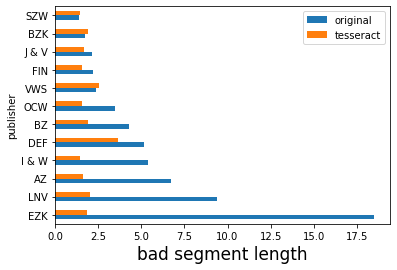

In [39]:
# maak een plotje waarbij we alleen dat laatste figuur laten zien.
df3 = pd.DataFrame({'original': pdftotext_results_ministeries.groupby('publisher')['Mean Bad Segment Length'].mean(),
      'tesseract': tesseract_results_ministeries.groupby('publisher')['Mean Bad Segment Length'].mean()}).sort_values(by='original', ascending=False)
df3.T.rename(translation_dict, axis=1).T.plot.barh()
plt.xlabel('bad segment length', fontsize=17)
plt.show()

This plot is very interesting, as it shows as that not only Tesseract has  much shorter lenghts of bad segments, the variance between the different ministries is also a lot lower. 

As we can see from both the plots and the describe tables above, the Tesseract method has higher quality OCR compared to pdftotext using this bad segment detection method. It also shows that on average (and definitely for Tesseract), the bad segment length is only a few words, which would make correction hopefully easier. However, it might also mean that when using chatgpt we might want to give the model some surrounding text to help, otherwise it would just be correction single wrong words without a clue of the context, causing it to make assumptions on general language statistics that might not hold for this very specific usecase.

<h1><a id="chatgpt">ChatGPT</a></h1>


Now that we have a method of detecting bad segments, let's try correcting them with chatGPT. We could also use the Davinci model, which is specifically trained for this kind of single turn tasks, performance should be about the same, but Davinci is more expensive to run.

For this part I am interested in several types of mistakes: streams of concatenated words, short segments with minor mistakes and segments that are complete gibberish. Because especially for Tesseract the mean bad segment length is quite short (just a few tokens), I will mix up the long and short sentences so that we get a nice estimate on the performance of the correction step. Because some of the mistakes are irrecoverable, we try to combat this by adding to the prompt.

In [42]:
# set up the API, please replace this key below with your personal key
import os
import openai

openai.api_key = "INSERT YOUR TOKEN HERE"

# small function to get the output of the ChatGPT model
def get_response(prompt: str, model) -> str:
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages, temperature=0.0)
    return response.choices[0].message["content"]

For the correction task a relative short precise prompt works well, I have modified it slightly so that it removes any markup (the triple backticks) that were in the original sentence. Below is a small summary of my iterative prompt design, and why I made certain adjustements to the prompt.

We also write a short wrapper function to be able to just insert our sentences. Let's set up the boilerplate code and show an example.

### Prompt Design for ChatGPT

In [43]:
correction_prompt ="""
Correct the spelling mistakes in the following Dutch text delimited by triple backticks and remove the triple backtiks afterwards.
Leave the correct words untouched.
```%s```

"""
# small lambda function to easily change the input sentences with the same prompt
prompt_with_sentence = lambda sentence: correction_prompt % sentence

Here we write a function that extracts the text from the bad segments in pages, runs ChatGPT and saves the result. We then do the same calculations as we did before, run our bad segment detector and seeing how well this works.
We end with a small manual evaluation of the corrected sentences as well.

In [44]:
bad_segment_detector = BadSegmentDetector()
def correct_text_with_chatgpt(input_document: str, context_size: int = 5) -> str:
    """
    This function implements a document correction method using chatGPT, where we take as input
    a page, detect bad segments, send these to chatgpt for correction, and place them back into the original text.
    :param input_document: string that contains the input text with errors that we want to correct.
    :param context_size: int specifying the number of words that we want to include as context for the 
    model to help it in correctiong shorter segments.
    
    """
    # The first step is to detect bad segments
    detected_bad_segments = bad_segment_detector.detect_bad_segments(input_document, clean_input=False)
    # Now we get the bad segments from the text, including a little bit of context in the response.
    tokens = preprocess(input_document)
    bad_indices = []
    if detected_bad_segments[0]:
        bad_seg_idx = [0]
    else:
        # no bad segments
        bad_seg_idx = []
    
    # get a list of lists with the start and end indices in it
    for i in range(1, len(detected_bad_segments)):
        if [detected_bad_segments[i-1], detected_bad_segments[i]] == [False, True]:
            bad_seg_idx.append(i)
        elif [detected_bad_segments[i-1], detected_bad_segments[i]] == [True, False]:
            bad_seg_idx.append(i-1)
            bad_indices.append(bad_seg_idx)
            bad_seg_idx = []
    # clean up
    if len(bad_seg_idx):
        bad_seg_idx.append(len(detected_bad_segments)-1)
    
    if all(detected_bad_segments):
        bad_indices = [[0, len(tokens)-1]]
        
    segment_pairs = []
    corrected_segments = {}
    # Now we can feed add some context and feed this to chat GPT
    for start_idx, end_idx in bad_indices:
        start_with_context = start_idx-context_size if start_idx-context_size >=0 else start_idx
        end_with_context = end_idx+1+context_size if end_idx+1+context_size < len(tokens) else len(tokens)
        input_text = " ".join(tokens[start_with_context:end_with_context])
        corrected_text = get_response(prompt_with_sentence(input_text), model="gpt-3.5-turbo-0301")
        corrected_text = " ".join(corrected_text.split()[(start_idx-start_with_context): (start_idx-start_with_context)+(end_idx-start_idx)+1])
        segment_pairs.append([" ".join(tokens[start_idx:end_idx+1]), corrected_text])
        corrected_segments[(start_idx, end_idx)] = corrected_text

    # We have to be careful when placing things back in the original texts because we are working with lists of tokens
    replaced_text = []
    bad_segment_keys = list(corrected_segments.keys())
    for i in range(len(tokens)):
        in_segment = False
        for bad_seg_key in bad_segment_keys:
            if i == bad_seg_key[0]:
                in_segment=True
                replaced_text.append(corrected_segments[bad_seg_key])
            elif i in range(bad_seg_key[0], bad_seg_key[1]+1):
                in_segment = True
        if not in_segment:
            replaced_text.append(tokens[i])
    
    return{'text': " ".join(replaced_text), 'pairs': segment_pairs}
        


Let's try and example of a very bad segment from the dataset and see what ChatGPT can do with it.

In [45]:
very_bad_segment = """
 auo asewordig jesnyjng zo uy aul asebuny jo asoysiy y aaiuns of naa ul btuwioy uea jnapessegwuy eyuauy yd uea apessequy juauewsag assee3uoh uauewusg asseebu0h japsa1ds jba yooiaim uarsaprz ngonaeg yawyy sapwaig asyiny voueqi 9tozse uoueqn 9t02se uoueadn 9t0zs uovegr 9t02se puepapan puejapin 9t0es6t puejsapan 9tozdet puejsyng 9tijde puersying 9toleot pueisiing 9tote9t ¢ stozsot pubhspan otozest puehapin 9tozsot puepeppenn stozsb puejjapan sp purlbpin 9tozb ueiiked 9tozsot puepsapan 9t0z0l puepapan 9tozsot puejsapan 9tozvsz enawy jtozvzz puejapan stozsot ppuepapan stotsot puejlapann 9tozsot puejsapan 9tozviz puepapann 9tozpbz puejsapan 9t0tv8t afanl 9totete pywouy 9tozete eyuawiy 9t02ete puepapay puepapan ppuejsapan otozest puelapan 9toz epawy 9toze puelipin otoze puchopsn otoz pueejjapann 9tozb ajsaunl otozez puclopon otozlt afsesuoy 9to72t afue8uoy ppueapan 9toz puejsapan 9tozzzz,
"""
correction_prompt_original ="""
Correct the following Dutch text containing spelling mistakes delimited by triple backticks and remove the triple backticks afterwards.
Leave the correct words untouched. '
```{%s}```

"""
prompt_with_sentence = lambda sentence: correction_prompt_original % sentence
corrected_sentence_original = get_response(prompt_with_sentence(very_bad_segment), model="gpt-3.5-turbo-0301")

AuthenticationError: <empty message>

In [91]:
very_bad_segment

'\n auo asewordig jesnyjng zo uy aul asebuny jo asoysiy y aaiuns of naa ul btuwioy uea jnapessegwuy eyuauy yd uea apessequy juauewsag assee3uoh uauewusg asseebu0h japsa1ds jba yooiaim uarsaprz ngonaeg yawyy sapwaig asyiny voueqi 9tozse uoueqn 9t02se uoueadn 9t0zs uovegr 9t02se puepapan puejapin 9t0es6t puejsapan 9tozdet puejsyng 9tijde puersying 9toleot pueisiing 9tote9t ¢ stozsot pubhspan otozest puehapin 9tozsot puepeppenn stozsb puejjapan sp purlbpin 9tozb ueiiked 9tozsot puepsapan 9t0z0l puepapan 9tozsot puejsapan 9tozvsz enawy jtozvzz puejapan stozsot ppuepapan stotsot puejlapann 9tozsot puejsapan 9tozviz puepapann 9tozpbz puejsapan 9t0tv8t afanl 9totete pywouy 9tozete eyuawiy 9t02ete puepapay puepapan ppuejsapan otozest puelapan 9toz epawy 9toze puelipin otoze puchopsn otoz pueejjapann 9tozb ajsaunl otozez puclopon otozlt afsesuoy 9to72t afue8uoy ppueapan 9toz puejsapan 9tozzzz,\n'

In [92]:
corrected_sentence_original

"```\nAuto's zijn tegenwoordig zo'n belangrijk onderdeel van ons dagelijks leven dat we ons moeilijk een bestaan zonder auto's kunnen voorstellen. Of we nu naar ons werk gaan, boodschappen doen of op vakantie gaan, we hebben onze auto's nodig. Maar helaas brengen auto's ook veel problemen met zich mee, zoals verkeersongevallen, hoge kosten en milieuvervuiling. Om deze problemen aan te pakken, moeten we ons bewust zijn van onze verantwoordelijkheid en ons gedrag aanpassen. Alleen dan kunnen we een duurzame toekomst voor onszelf en onze kinderen veiligstellen.```\n"

Here we can see the danger: the original text is of too low quality, and should be sent back for correction. However, chatgpt will happily go ahead on generate a grammatical sentence, which is completely wrong in this context. There are two options: Either we automatically reject segments that are longer than a certain size, or we can see if we can get chatgpt to filter this out itself.

One of the issues that we can have with ChatGPT is that, in general, it will be able to repair non-words and convert them to correct dutch words. However, this does of course not have to be the correct word with regards to the original text. For this, we compare two more things: whether the number of tokens returned by ChatGPT is equal to the number of tokens in the original text, and, if this is the case, what the Levenshtein distance between the tokens is.

## Detailed Evaluation of ChatGPT output

For this we load the converted pages from our saved dataframe (i will first combine them), then we will compare them to the tesseract text with the bad segment statistics, and check out the token level distances.

We will select pages that are relatively bad, so that there are some things to correct, we take the pages sorted on the number of bad tokens, and randomly sample pages between

In [93]:
# randomly select the samples
selected_besluiten = pdftotext_results.sample(100)
selected_ids = selected_besluiten['ID'].tolist()

In [94]:
chatgpt_input = experiment_dataframe[experiment_dataframe['ID'].isin(selected_ids)]

In [95]:
# select 100 bad pages
from tqdm import tqdm
def get_chatgpt_for_pages(dataframe, text_type: str = 'tesseract'):
    missed_pages = []
    all_token_pairs = {}
    all_corrected_texts = {}
    for _, page in tqdm(dataframe.iterrows()):
        try:
            input_text = page[text_type]
            page_id = page['ID']
            chatgpt_output = correct_text_with_chatgpt(input_text)

            all_token_pairs[page_id] = chatgpt_output['pairs']
            all_corrected_texts[page_id] = chatgpt_output['text'] 
        except openai.error.RateLimitError as r:
            missed_pages.append(page_id)
        except openai.error.APIError as a:
            missed_pages.append(page_id)
    return all_token_pairs, all_corrected_texts


In [96]:
pdftotext_chatgpt_token_pairs, pdftotext_chatgpt_text = get_chatgpt_for_pages(chatgpt_input, text_type='original')
tesseract_chatgpt_token_pairs, tesseract_chatgpt_text = get_chatgpt_for_pages(chatgpt_input, text_type='teseract')

45it [2:29:23, 199.18s/it]


Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

As the main goal here is to compare to the texts without ChatGPT we get the stats of the versions without ChatGPT of the selected sample, so that we can compare it to the versions we corrected with ChatGPT.

In [72]:
pdftotext_results[pdftotext_results['ID'].isin(selected_ids)].describe().round(2)

,Number of bad Segments,Mean Bad Segment Length,Max Bad Segment Length,Min Bad Segment Length,Number of bad Tokens,Bad Ratio,Num Tokens
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,7.91,8.98,13.18,7.65,28.63,0.13,269.51
std,8.11,43.16,47.46,42.45,66.49,0.25,150.27
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2.00,1.00,1.00,1.00,3.00,0.02,142.50
50%,6.00,1.40,3.00,1.00,10.50,0.04,281.50
75%,11.00,2.16,6.00,1.00,19.50,0.09,373.75
max,51.00,363.00,363.00,363.00,365.00,1.00,699.00


In [73]:
tesseract_results[tesseract_results['ID'].isin(selected_ids)].describe().round(2)

,Number of bad Segments,Mean Bad Segment Length,Max Bad Segment Length,Min Bad Segment Length,Number of bad Tokens,Bad Ratio,Num Tokens
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,6.60,1.75,5.82,1.01,15.22,0.06,277.57
std,6.09,2.13,15.64,0.50,33.63,0.12,147.65
min,0.00,0.00,0.00,0.00,0.00,0.00,11.00
25%,2.00,1.00,1.00,1.00,3.00,0.01,144.50
50%,5.00,1.22,2.50,1.00,8.00,0.03,285.50
75%,9.00,1.88,5.00,1.00,15.25,0.06,381.50
max,41.00,20.18,113.00,4.00,231.00,0.83,676.00


In [218]:
pdf_chatgpt_results.describe().round(2)

NameError: name 'pdf_chatgpt_results' is not defined

In [219]:
tes_chatgpt_results.describe().round(2)

NameError: name 'tes_chatgpt_results' is not defined

## PDF Layout Conversion